In [1]:
import pandas as pd
import statsmodels.api as sm
from itertools import chain, combinations
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/levers.csv").set_index('emp_id', drop=True)

In [3]:
X = df.iloc[:, :-1]
y = df[['num_calls']]

In [4]:
def best_subset(X, y):
    n_features = X.shape[1]
    subsets = chain.from_iterable(combinations(X.columns, k+1) for k in np.arange(n_features))
    best_score = -np.inf
    best_subset = None
    for subset in subsets:
        subset = list(subset)
        lin_reg = sm.OLS(y, X[subset]).fit()
        score = lin_reg.rsquared_adj
        if score > best_score:
            best_score, best_subset = score, subset

    print(f"Best ML-regression: {best_subset}; R^2: {best_score}")

    return best_subset

In [5]:
def show_resid(X, y):
    print("="*80)
    print("Best Subset of Features:")
    print("-"*80)
    X_best = X[best_subset(X, y)]
    print("*"*80)
    model = sm.OLS(y, sm.add_constant(X_best)).fit()
    print("Feature Weights:")
    print("-"*80)
    print(model.params)
    print("*"*80)
    print("Residual Plot:")
    sns.residplot(x=y, y=model.resid, lowess=True, line_kws={'color': 'red', 'lw': 2, 'alpha': 0.7})
    plt.show()


Using month to month data we are attempting to find a metric which best approximates employee call load. We begin by finding which features provide us with the best approximation, then fitting this data to the raw call count. Once these features are identified they are assigned a weighted value for which out line of best fit will utilize.

Best Subset of Features:
--------------------------------------------------------------------------------
Best ML-regression: ['prev_month_sales', 'employee_age', 'sales_training', 'conversion', 'compensation_plan']; R^2: 0.8404702219178839
********************************************************************************
Feature Weights:
--------------------------------------------------------------------------------
const                75.449489
prev_month_sales     -0.836804
employee_age          0.486470
sales_training       -0.050397
conversion           25.563128
compensation_plan    20.820815
dtype: float64
********************************************************************************
Residual Plot:


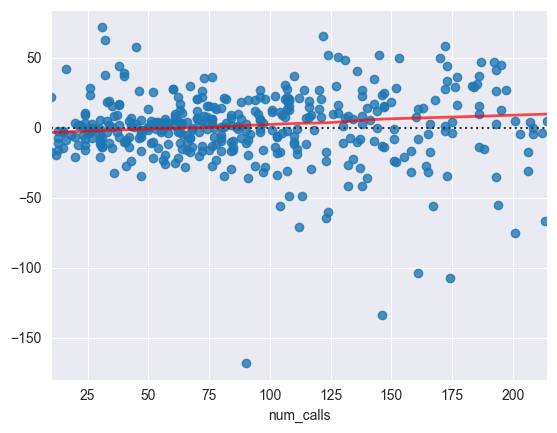

In [6]:
show_resid(X, y);

With an $R^2=0.8405$ our regression is solid, but has room for improvement. Logically, does it make sense for us to measure efficiency through raw call volume? As call volume increases, the weight of a single call becomes less impactful. The way we can justify this is to take the natural log of the calls. This will provide a metric for call magnitude and in turn should lead to a better fit.

Best Subset of Features:
--------------------------------------------------------------------------------
Best ML-regression: ['prev_month_sales', 'employee_age', 'sales_training', 'conversion', 'compensation_plan']; R^2: 0.951769683161236
********************************************************************************
Feature Weights:
--------------------------------------------------------------------------------
const                4.115996
prev_month_sales    -0.010599
employee_age         0.007113
sales_training      -0.002093
conversion           0.309479
compensation_plan    0.247688
dtype: float64
********************************************************************************
Residual Plot:


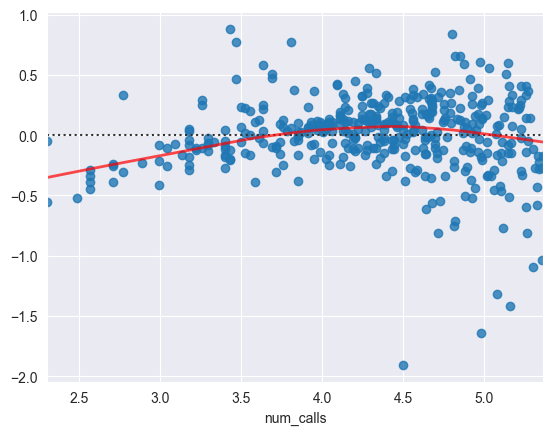

In [7]:
show_resid(X, np.log(y));

With an $R^2=0.9518$ we are able to improve our mapping by $13.2\%.$